# YoMaHa'07 data: Lomb Scargle periodograms, frequency estimation

In [ ]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import matplotlib.gridspec as gs
import h5py
import cftime
from astropy import timeseries
from warnings import filterwarnings
import dask.config as dc
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

import sys
sys.path.append("modules/")
import prepare_and_bin

In [ ]:
# set up batchjob

cluster = SLURMCluster(
    partition="cluster",
    walltime="08:00:00",
    cores=8,
    processes=8,
    memory="20 GB",
    env_extra=[
        "export LC_ALL=en_US.UTF-8",
        "export LANG=en_US.UTF-8"],
    interface="ib0")

In [ ]:
client = Client(cluster)
# add nodes
cluster.scale(64)

# Figure 5 (frequency)

In [ ]:
# load Yomaha data, select equatorial ocean and 1000m depth
lon, lat, time, depth, u = prepare_and_bin.prepare_argo("data/yomaha/yomaha07.dat", 1000, (-7,7))

In [ ]:
# Lomb Scargle periodograms for Panel a

freq_Atl = np.arange(0, 3, 0.001)
amplitude_Atl = np.zeros((8, len(freq_Atl)))
counter_Atl=0

for i in range(-40, 0, 5): # 40W to 0E
    u_temp_Atl = u[(lat>=-1) & (lat<=1) & (lon>=i) & (lon<i+5)]
    time_temp_Atl = time[(lat>=-1) & (lat<=1) & (lon>=i) & (lon<i+5)]
    power_Atl = timeseries.LombScargle(time_temp_Atl/365.25, 
                                      u_temp_Atl, normalization="psd"
                                      ).power(freq_Atl)
    
    # make amplitude normalization right
    amplitude_Atl[counter_Atl, :] = np.sqrt(power_Atl / len(time_temp_Atl)) * 2 
    counter_Atl = counter_Atl+1

# detect peak frequency
peak_freq = freq_Atl[np.nanargmax(np.mean(amplitude_Atl, axis=0))]

## Bootstrapping

In [ ]:
# load and select data
lon_all, lat_all, time_all, depth_all, u_all = prepare_and_bin.prepare_argo("data/yomaha07.dat", 1000, (-1,1))

# select Atlantic
lon_Atl = lon_all[(lon_all > -55) & (lon_all < 15)]
lat_Atl = lat_all[(lon_all > -55) & (lon_all < 15)]
time_Atl = time_all[(lon_all > -55) & (lon_all < 15)]
depth_Atl = depth_all[(lon_all > -55) & (lon_all < 15)]
u_Atl = u_all[(lon_all > -55) & (lon_all < 15)]

In [ ]:
freq = np.arange(0, 1, 0.0002)   # frequency vector for Lomb Scargle periodograms

In [ ]:
# define function that does the ressampling of time series

def spec_bootstrapping(u, time):   
    # draw sample from original data (with replacement and same length)
    inds = np.random.choice(np.arange(0, len(u)), size=len(u), replace=True)  # indices necessary for keeping integrity of u/time pairs
    sample_u = u[inds]
    sample_time = time[inds]
    return (sample_u, sample_time)

In [ ]:
# define wrapper function that iterates over longitude bins, averages periodograms and returns the dominant frequency

def frequency_estimation(N):   # N is dummy argument used for mapping N times to dask workers
    power = np.zeros((8, len(freq)))
    counter = 0
    
    for i in range(-40, 0, 5): # 40W to 0E
        u_temp = u_Atl[(lon_Atl>=i) & (lon_Atl<i+5)]
        time_temp = time_Atl[(lon_Atl>=i) & (lon_Atl<i+5)]
        (sample_u, sample_time) = spec_bootstrapping(u_temp, time_temp)
        power[counter,:] = timeseries.LombScargle(sample_time/365.25, 
                                      sample_u, normalization="psd"
                                      ).power(freq)   
        counter = counter+1
    dom_freq = freq[np.nanargmax(np.mean(power, axis=0))]
    
    return dom_freq

In [ ]:
freqfutures = client.map(frequency_estimation, np.arange(0, 10000))   # do calculation 10,000 times in parallel on dask cluster

In [ ]:
%%time
frequencies = client.gather(freqfutures)

In [ ]:
# save data for plotting and table
yomaha_frequencies_bootstrapping = xr.Dataset({"peak_frequencies": (["bootstrapping_instance"], frequencies)},
                                             coords={"bootstrapping_instance": (["bootstrapping_instance"], np.arange(0, len(frequencies)))})
yomaha_frequencies_bootstrapping.to_netcdf("derived_data/yomaha_frequencies_bootstrapping.nc", mode="w")

## Mooring data (for panel c)

In [ ]:
# load mooring data from 23W
with h5py.File("data/Mooring_data/velocities_23W_2001_2019_interp.mat", "r") as file:
    U = np.array(file['U'])
    V = np.array(file['V'])
    P = np.array(file['P'])
    time = np.array(file['TIME'])
    
vel_23W_obs = xr.Dataset({'u':(['pres', 'time'], U.transpose()),
                         'v':(['pres', 'time'], V.transpose())},
                        coords={'pres': P[:,0],
                               'time': cftime.num2date(time[0,:]-365, 'days since 0001-01-01')}
                        )
vel_23W_obs = vel_23W_obs.chunk({'pres':20,'time':100})

In [ ]:
# select zonal velocity, 250-2500m depth
u_selected = vel_23W_obs.u.sel(pres=slice(250, 2500))
# resample to monthly data
monthly_u = u_selected.resample(time="MS").mean()
# new time axis, in years, with January 2000 as zero
new_time_in_days = cftime.date2num(monthly_u.time, "days since 2000-01-01")
new_time_in_years = new_time_in_days / 365.25

In [ ]:
warnings.filterwarnings("ignore")

freq = np.arange(0, 0.4, 0.0002)    # in 1/year
amplitude = np.zeros(len(freq))[:, None]
depth_axis = np.asarray([0])

for i in monthly_u.pres.values:
    profile = monthly_u.sel(pres=slice(i-20, i+20)).mean(dim="pres").persist()
        
    if np.sum(np.isfinite(profile.values)) > 50: 
        data_temp = np.squeeze(profile.values[np.isfinite(profile.values)])
        time_temp = new_time_in_years[np.squeeze(np.isfinite(profile.values))]
            
            
        power_temp = timeseries.LombScargle(time_temp, data_temp, normalization="psd").power(freq)
        # make normalization right
        amplitude_temp = np.sqrt(power_temp / len(time_temp)) * 2
        amplitude = np.append(amplitude, amplitude_temp[:, np.newaxis], axis=1)
        depth_axis = np.append(depth_axis, i)
        
mooring_frequency_with_depth = xr.Dataset({"max_freq": (["depth"], freq[900:1300][np.nanargmax(amplitude[900:1300,1:], axis=0)])},
                                         coords={"depth": (["depth"], depth_axis[1:])})

## Figure 5

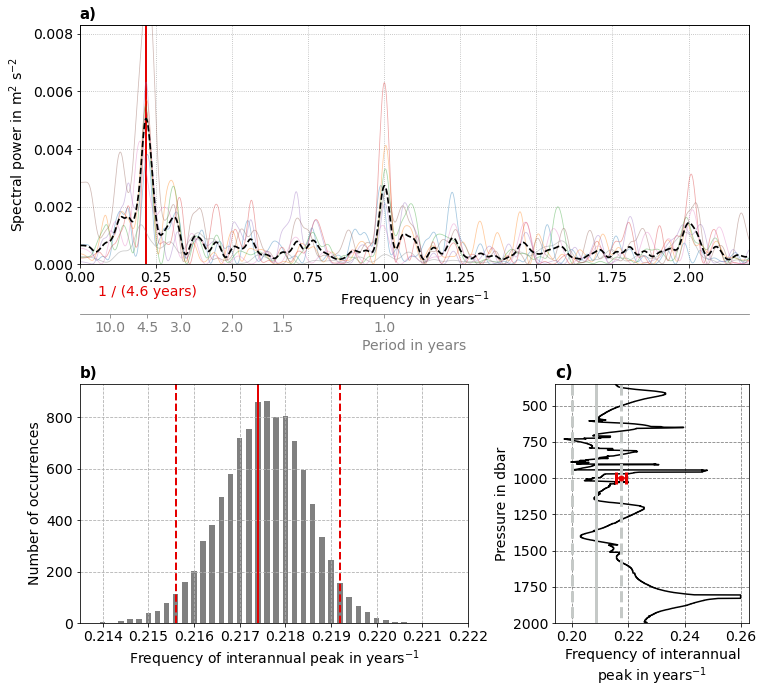

In [8]:
plt.figure(figsize=(12,11))

plt.rcParams["font.size"] = 14

gr = gs.GridSpec(2, 2, hspace=0.5, wspace=0.3, width_ratios=[2,1])


# Lomb-Scargle periodograms
ax1 = plt.subplot(gr[0,:])
plt.plot([peak_freq, peak_freq], 
         [0, 0.01], color="xkcd:red", linestyle="solid", linewidth=2)
plt.text(0.06, -0.0011, "1 / (4.6 years)", color="xkcd:red")
for i in range(0,8):
    l1, = plt.plot(freq_Atl, (amplitude_Atl[i,:] / 100)**2, alpha=0.4, linewidth=0.8)
l2, = plt.plot(freq_Atl, np.mean((amplitude_Atl / 100)**2, axis=0), color="black", linestyle="dashed", linewidth=1.7)
ax1.set_xlim([0, 2.2])
ax1.set_ylim([0, 0.0083])
plt.grid(linestyle="dotted")
plt.xlabel(r"Frequency in years$^{-1}$")
plt.ylabel(r"Spectral power in m$^2$ s$^{-2}$")
plt.title("a)", loc="left", fontsize=15, fontweight="bold")
# plt.legend((l1, l2), (r"Periodograms for 5$^{\circ}$ longitude bins", "Average of all periodograms"))


# second x axis with period
ax4a = ax1.twiny()
newlabel = [10., 4.5, 3., 2., 1.5, 1.]
newpos = [1./i for i in newlabel]
ax4a.set_xticks(newpos)
ax4a.set_xticklabels(newlabel)
ax4a.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax4a.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax4a.spines['bottom'].set_position(('outward', 50))
ax4a.spines['bottom'].set_color('grey')
ax4a.set_xlabel('Period in years', color='grey')
ax4a.tick_params(axis='x', colors='grey')
ax4a.set_xlim(ax1.get_xlim())


# Histogram from bootstrapping, also indicating the value from the real unchanged data
bins = np.arange(0.2131, 0.2218, 0.0002)

ax2 = plt.subplot(gr[1,0])
plt.hist(yomaha_frequencies_bootstrapping.peak_frequencies, bins=bins, color="grey", rwidth=0.6)
plt.plot([peak_freq, peak_freq], [0, 1000], color="xkcd:red", linewidth=2)
plt.plot([np.percentile(yomaha_frequencies_bootstrapping.peak_frequencies, 2.5), 
          np.percentile(yomaha_frequencies_bootstrapping.peak_frequencies, 2.5)], [0, 1000], color="xkcd:red", linestyle="dashed", linewidth=2)
plt.plot([np.percentile(yomaha_frequencies_bootstrapping.peak_frequencies, 97.5), 
          np.percentile(yomaha_frequencies_bootstrapping.peak_frequencies, 97.5)], [0, 1000], color="xkcd:red", linestyle="dashed", linewidth=2)
plt.grid(linestyle="dashed")
ax2.set_xticks(np.arange(0.213, 0.222, 0.001))
ax2.set_xlim([0.2135, 0.222])
ax2.set_ylim([0,930])
plt.xlabel(r"Frequency of interannual peak in years$^{-1}$")
plt.title("b)", loc="left", fontsize=15, fontweight="bold")
plt.ylabel("Number of occurrences");


# mooring data comparison
ax3 = plt.subplot(gr[1,1])
# mooring
plt.plot(mooring_frequency_with_depth.max_freq, mooring_frequency_with_depth.depth, color="black")
# Youngs & Johnson
plt.plot([1/4.6, 1/4.6], [350, 2000], color="xkcd:silver", linestyle="dashed", linewidth=3)
plt.plot([1/4.8, 1/4.8], [350, 2000], color="xkcd:silver", linestyle="solid", linewidth=3)
plt.plot([1/5, 1/5], [350, 2000], color="xkcd:silver", linestyle="dashed", linewidth=3)
# Argo
plt.errorbar(peak_freq, 1000,
             yerr=None, 
             xerr=np.asarray([(peak_freq - 
                               np.percentile(yomaha_frequencies_bootstrapping.peak_frequencies.values, 2.5)), 
                   (np.percentile(yomaha_frequencies_bootstrapping.peak_frequencies.values, 97.5) - 
                    peak_freq)])[:,None], 
             fmt="none", ecolor="xkcd:red", capsize=6, capthick=3)
plt.plot(peak_freq, 1000, marker=".", color="xkcd:red", markersize=10)
ax3.invert_yaxis()
ax3.grid(color="grey", linestyle="dashed")
ax3.set_yticks(np.arange(250,2750,250))
ax3.set_ylim([2000, 350])
plt.ylabel("Pressure in dbar")
plt.xlabel("Frequency of interannual\n" + r"peak in years$^{-1}$")
plt.title("c)", loc="left", fontweight="bold")


plt.savefig("Figures/Figure_5_frequency.pdf", bbox_inches="tight")

# Figure 13 (Indian and Pacific)

In [ ]:
# load Yomaha data, select equatorial ocean and 1000m depth
lon, lat, time, depth, u = prepare_and_bin.prepare_argo("data/yomaha/yomaha07.dat", 1000, (-7,7))

In [ ]:
# Indian Ocean

freq_Ind = np.arange(0, 3, 0.001)
amplitude_Ind = np.zeros((9, len(freq_Ind)))
counter_Ind=0

for i in range(50, 95, 5):
    u_temp_Ind = u[(lat>=-1) & (lat<=1) & (lon>=i) & (lon<i+5)]
    time_temp_Ind = time[(lat>=-1) & (lat<=1) & (lon>=i) & (lon<i+5)]
    power_Ind = timeseries.LombScargle(time_temp_Ind/365.25, 
                                      u_temp_Ind, normalization="psd"
                                      ).power(freq_Ind)   
    # make normalization right
    amplitude_Ind[counter_Ind, :] = np.sqrt(power_Ind / len(time_temp_Ind)) * 2 
    counter_Ind = counter_Ind+1
    
    
# Pacific Ocean

freq_Pac = np.arange(0, 3, 0.001)
amplitude_Pac = np.zeros((21, len(freq_Pac)))
counter_Pac=0

for i in range(160, 265, 5):
    u_temp_Pac = u[(lat>=-1) & (lat<=1) & (lon>=i) & (lon<i+5)]
    time_temp_Pac = time[(lat>=-1) & (lat<=1) & (lon>=i) & (lon<i+5)]
    power_Pac = timeseries.LombScargle(time_temp_Pac/365.25, 
                                      u_temp_Pac, normalization="psd"
                                      ).power(freq_Pac)   
    # make normalization right
    amplitude_Pac[counter_Pac, :] = np.sqrt(power_Pac / len(time_temp_Pac)) * 2 
    counter_Pac = counter_Pac+1

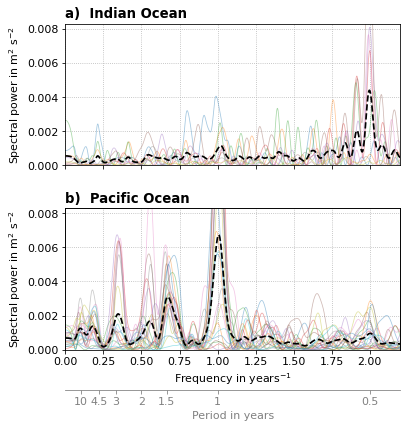

In [21]:
plt.rcParams["font.size"] = 11

plt.figure(figsize=(6, 6))

gr = gs.GridSpec(2, 1, hspace=0.3)


ax2 = plt.subplot(gr[0])
for i in range(0,9):
    l1, = plt.plot(freq_Ind, (amplitude_Ind[i,:] / 100)**2, alpha=0.4, linewidth=0.8)
l2, = plt.plot(freq_Ind, np.mean((amplitude_Ind / 100)**2, axis=0), color="black", linestyle="dashed", linewidth=1.7)
ax2.set_xlim([0, 2.2])
ax2.set_ylim([0, 0.0083])
plt.grid(linestyle="dotted")
ax2.set_xticklabels([])
plt.ylabel(r"Spectral power in m$^2$ s$^{-2}$")
plt.title("a)  Indian Ocean", loc="left", fontweight="bold")

ax3 = plt.subplot(gr[1])
for i in range(0,21):
    l1, = plt.plot(freq_Pac, (amplitude_Pac[i,:] / 100)**2, alpha=0.4, linewidth=0.8)
l2, = plt.plot(freq_Pac, np.mean((amplitude_Pac / 100)**2, axis=0), color="black", linestyle="dashed", linewidth=1.7)
ax3.set_xlim([0, 2.2])
ax3.set_ylim([0, 0.0083])
plt.grid(linestyle="dotted")
plt.xlabel(r"Frequency in years$^{-1}$")
plt.ylabel(r"Spectral power in m$^2$ s$^{-2}$")
plt.title("b)  Pacific Ocean", loc="left", fontweight="bold")

# second x axis with period
ax4a = ax3.twiny()
newlabel = [10, 4.5, 3, 2, 1.5, 1, 0.5]
newpos = [1./i for i in newlabel]
ax4a.set_xticks(newpos)
ax4a.set_xticklabels(newlabel)
ax4a.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax4a.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax4a.spines['bottom'].set_position(('outward', 40))
ax4a.spines['bottom'].set_color('grey')
ax4a.set_xlabel('Period in years', color='grey')
ax4a.tick_params(axis='x', colors='grey')
ax4a.set_xlim(ax3.get_xlim())

plt.savefig("Figures/Figure_13_IndianPacific.pdf", bbox_inches="tight", dpi=300)